In [4]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB
from gurobipy import quicksum
import gurobipy as gp
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from tqdm import tqdm
sns.set(style ="whitegrid", font_scale=1.5)
import sys
import os
import pickle
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)


# Demand File Processing & Viz

In [5]:
DTLA = pd.read_csv('../input/schedule_5min_0612.csv').reset_index()
LGB = pd.read_csv('../input/demand_variation/schedule/alpha_7_demand_1500/7_1.csv').reset_index()
WDHL = pd.read_csv('../input/demand_variation/schedule/alpha_7_demand_500/6_1.csv').reset_index()
ELSG = pd.read_csv('../input/demand_variation/schedule/alpha_7_demand_2500/5_1.csv').reset_index()
UVS = pd.read_csv('../input/demand_variation/schedule/alpha_7_demand_500/3_1.csv').reset_index()

In [6]:
DTLA['schedule'] = np.ceil(DTLA['schedule']/5)
LGB['schedule'] = np.ceil(LGB['schedule']/5)
WDHL['schedule'] = np.ceil(WDHL['schedule']/5)
UVS['schedule'] = np.ceil(UVS['schedule']/5)

DTLA['origin'] = DTLA['od'].apply(lambda x: 0 if x.split('_')[0] == 'LAX' else 1)
LGB['origin'] = LGB['od'].apply(lambda x: 0 if x.split('_')[0] == 'LAX' else 2)
WDHL['origin'] = WDHL['od'].apply(lambda x: 0 if x.split('_')[0] == 'LAX' else 3)
UVS['origin'] = UVS['od'].apply(lambda x: 0 if x.split('_')[0] == 'LAX' else 4)

DTLA['destination'] = DTLA['od'].apply(lambda x: 0 if x.split('_')[1] == 'LAX' else 1)
LGB['destination'] = LGB['od'].apply(lambda x: 0 if x.split('_')[1] == 'LAX' else 2)
WDHL['destination'] = WDHL['od'].apply(lambda x: 0 if x.split('_')[1] == 'LAX' else 3)
UVS['destination'] = UVS['od'].apply(lambda x: 0 if x.split('_')[1] == 'LAX' else 4)

In [7]:
def get_num_flight_both_dir(leg_demand, agg_window):
    LAX_X = leg_demand[leg_demand['origin'] == 0]['schedule'].to_numpy() / (12)
    X_LAX = leg_demand[leg_demand['destination'] == 0]['schedule'].to_numpy() / (12)
    
    LAX_X_hourly = np.histogram(LAX_X, bins = agg_window)[0]
    X_LAX_hourly = np.histogram(X_LAX, bins = agg_window)[0]

    return LAX_X_hourly, X_LAX_hourly

def plot_single_leg(num_flight, label, color, ax):
    LAX_X_hourly, X_LAX_hourly = num_flight
    LAX_X_label, X_LAX_label = label
    LAX_X_color, X_LAX_color = color

    sns.lineplot(y=LAX_X_hourly, x=agg_window[:-1], 
             linewidth=1, ax=ax[0], label=LAX_X_label, marker='o', color=LAX_X_color)
    sns.lineplot(y=X_LAX_hourly, x=agg_window[:-1], 
                linewidth=1, ax=ax[1], label=X_LAX_label, marker='o', color=X_LAX_color)



In [8]:
from matplotlib.ticker import MultipleLocator
import matplotlib
color_platte = ['#93003a', '#00429d', '#93c4d2', '#6ebf7c']
matplotlib.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})

agg_window = np.arange(0, 25, 1)

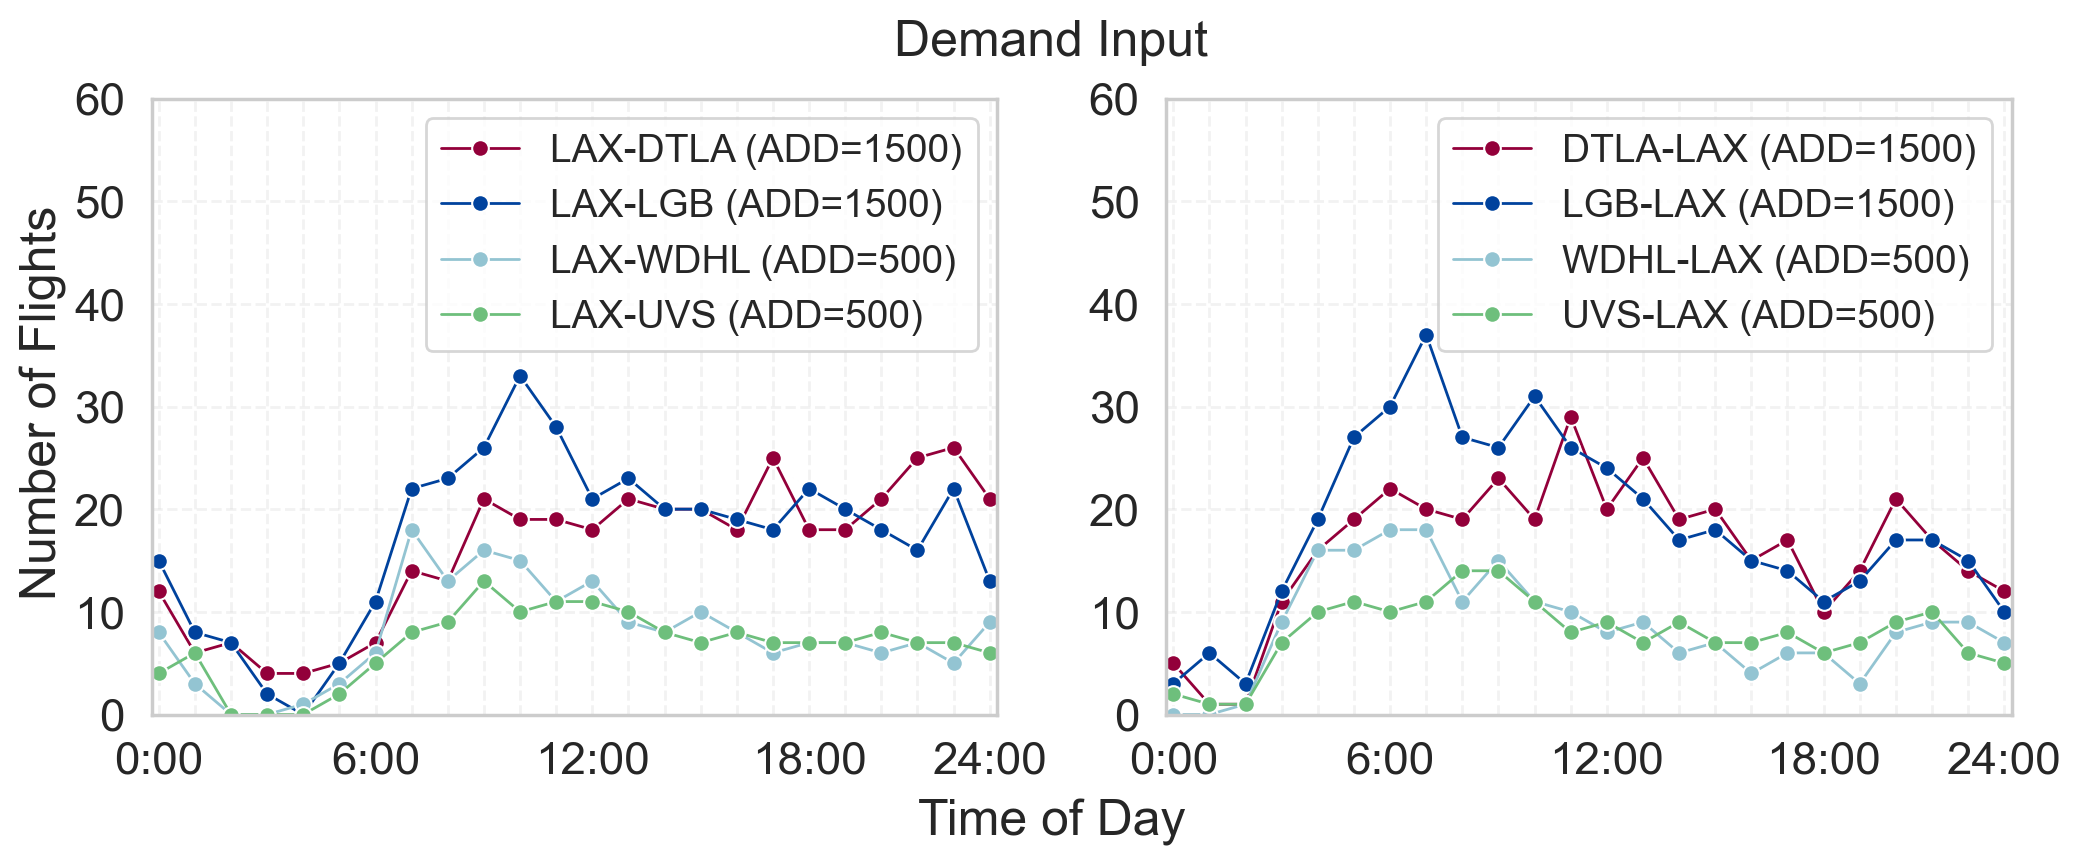

In [9]:
fig, ax = plt.subplots(dpi=200, figsize=(12,4), ncols=2)

LAX_DTLA_hourly, DTLA_LAX_hourly = get_num_flight_both_dir(DTLA, agg_window)
plot_single_leg((LAX_DTLA_hourly, DTLA_LAX_hourly), 
                ('LAX-DTLA (ADD=1500)', 'DTLA-LAX (ADD=1500)'), 
                (color_platte[0], color_platte[0]), ax)

LAX_LGB_hourly, LGB_LAX_hourly = get_num_flight_both_dir(LGB, agg_window)
plot_single_leg((LAX_LGB_hourly, LGB_LAX_hourly), 
                ('LAX-LGB (ADD=1500)', 'LGB-LAX (ADD=1500)'), 
                (color_platte[1], color_platte[1]), ax)

LAX_WDHL_hourly, WDHL_LAX_hourly = get_num_flight_both_dir(WDHL, agg_window)
plot_single_leg((LAX_WDHL_hourly, WDHL_LAX_hourly), 
                ('LAX-WDHL (ADD=500)', 'WDHL-LAX (ADD=500)'), 
                (color_platte[2], color_platte[2]), ax)

LAX_UVS_hourly, UVS_LAX_hourly = get_num_flight_both_dir(UVS, agg_window)
plot_single_leg((LAX_UVS_hourly, UVS_LAX_hourly), 
                ('LAX-UVS (ADD=500)', 'UVS-LAX (ADD=500)'), 
                (color_platte[3], color_platte[3]), ax)

minorLocator = MultipleLocator(1)
for i in range(2):
    ax[i].set(xlabel='', ylabel='', 
                xticks=[0,6,12,18,24-1], xticklabels=['0:00', '6:00', '12:00', '18:00', '24:00'],
                ylim=(0,60),
                xlim=(-0.2,23.2));
    ax[i].xaxis.set_minor_locator(minorLocator)
    ax[i].grid(True, alpha=0.25, linestyle='--', which='both')

fig.text(0.5, 0.95, 'Demand Input', ha='center', va='center')
fig.text(0.08, 0.5, 'Number of Flights', ha='center', va='center', rotation='vertical')
fig.text(0.5, -0.025, 'Time of Day', ha='center', va='center');


# UB: The Assignment Problem

In [10]:
import model.topology
importlib.reload(model.topology)
from model.topology import AssignmentNetwork, FlightTask

## Build out the network and tasks

In [8]:
flight_time = np.array([[0,2,3,4,4],
                        [2,0,5,6,6],
                        [3,5,0,7,7],
                        [4,6,7,0,8],
                        [4,6,7,8,0]])

charging_time = np.array([[0,1,1,2,2],
                          [1,0,2,3,3],
                          [1,2,0,3,3],
                          [2,3,3,0,4],
                          [2,3,3,4,0]])

repurposing_time = flight_time + charging_time

all_tasks = []    
for i, row in DTLA.iterrows():
    all_tasks.append(FlightTask('DTLA_'+str(row['index']), int(row['schedule']), repurposing_time, row['origin'], row['destination']))
for i, row in LGB.iterrows():
    all_tasks.append(FlightTask('LGB_'+str(row['index']), int(row['schedule']), repurposing_time, row['origin'], row['destination']))
for i, row in WDHL.iterrows():
    all_tasks.append(FlightTask('WDHL_'+str(row['index']), int(row['schedule']), repurposing_time, row['origin'], row['destination']))
for i, row in UVS.iterrows():
    all_tasks.append(FlightTask('UVS_'+str(row['index']), int(row['schedule']), repurposing_time, row['origin'], row['destination']))

all_tasks = sorted(all_tasks, key=lambda x: x.start_time)

In [9]:
network = AssignmentNetwork(all_tasks)
nodes, supply, edges, cost, c = network.populate_network()

## Solve the problem

In [ ]:
m = Model("MCNF")

flow = m.addVars(edges, obj=cost, name="flow", lb=0)
for n in tqdm(nodes):
    m.addConstr(sum(flow[i, j] for i, j in edges if j == n) -
                sum(flow[i, j] for i, j in edges if i == n) == supply.get(n, 0), f"node_{n}")

for edge in tqdm(edges):
    edge_source = edge[0]
    edge_target = edge[1]
    if len(edge_source) == 2 & len(edge_target) == 2:
        if edge_source[0] == edge_target[0]:
            if (edge_source[1] == 'start') & (edge_target[1] == 'finish'):
                m.addConstr(flow[edge_source, edge_target] == 1, f"flow_{edge_source}_to_{edge_target}")
    
m.setParam('OutputFlag', 0)                
m.optimize()
print('Optimal Fleetsize: %g' % m.objVal)

In [ ]:
with open('../output/star_network/assignment/NETWORK.txt', 'w') as f:
    for v in m.getVars():
        f.write(f'{v.varName} = {v.x}\n')

# IP

In [ ]:
os.chdir('../')
from model.IP import FleetSizeOptimizer

fso_DTLA = FleetSizeOptimizer(flight_time=np.array([[0,10],[10,0]]), 
                              energy_consumption=np.array([[0,10],[10,0]]), 
                              schedule='schedule_5min_0612.csv')
fso_DTLA.optimize(output_path='star_network/DTLA', optimality_gap=0.01, verbose=False)


fso_LGB = FleetSizeOptimizer(flight_time=np.array([[0,15],[15,0]]),
                             energy_consumption=np.array([[0,10],[10,0]]), 
                             schedule='demand_variation/schedule/alpha_7_demand_1500/7_1.csv')
fso_LGB.optimize(output_path='star_network/LGB', optimality_gap=0.01, verbose=False)

fso_WDHL = FleetSizeOptimizer(flight_time=np.array([[0,20],[20,0]]),
                              energy_consumption=np.array([[0,10],[10,0]]), 
                              schedule='demand_variation/schedule/alpha_7_demand_500/6_1.csv')
fso_WDHL.optimize(output_path='star_network/WDHL', optimality_gap=0.01, verbose=False)

fso_UVS = FleetSizeOptimizer(flight_time=np.array([[0,25],[25,0]]),
                             energy_consumption=np.array([[0,10],[10,0]]), 
                             schedule='demand_variation/schedule/alpha_7_demand_500/3_1.csv')
fso_UVS.optimize(output_path='star_network/UVS', optimality_gap=0.01, verbose=False)

os.chdir('MinCostNetFlow')

14

# LB: Linear Relaxation and Lagrangian Relaxation

In [290]:
import model.topology
import importlib
importlib.reload(model.topology)
from model.topology import AssignmentNetwork, FlightTask, ChargingNetwork

## Build out the network

In [27]:
vertiports = ['LAX', 'DTLA', 'LGB', 'WDHL', 'UVS']

flight_time = np.array([[0,2,3,4,4],
                        [2,0,5,6,6],
                        [3,5,0,7,7],
                        [4,6,7,0,8],
                        [4,6,7,8,0]])

# Units for energy consumption is levels of %SoC
energy_consumption = np.array([[0,10,15,20,25],
                               [10,0,25,30,35],
                               [15,25,0,35,35],
                               [20,30,35,0,40],
                               [25,35,35,40,0]]) / 2.5
energy_consumption = energy_consumption.astype(int)

od_matrix = np.array([[0,1,1,1,1],
                      [1,0,1,1,1],
                      [1,1,0,1,1],
                      [1,1,1,0,1],
                      [1,1,1,1,0]])

In [28]:
network2 = ChargingNetwork(vertiports, flight_time, energy_consumption, od_matrix)
nodes, supply, edges, cost, c = network2.populate_network()

In [120]:
def obtain_demand_dict(df, existing_dict=None):
    if existing_dict is not None:
        demand_dict = existing_dict
    else:
        demand_dict = {}
        
    df_grouped = df.groupby(['origin', 'destination', 'schedule']).size().reset_index(name='count')
    for i, row in df_grouped.iterrows():
        demand_dict[(int(row['origin']), int(row['destination']), int(row['schedule']))] = int(row['count'])
    return demand_dict

In [121]:
od_key = {'LAX':0, 'DTLA':1, 'LGB':2, 'WDHL':3, 'UVS':4}
flight_demand = obtain_demand_dict(DTLA)
flight_demand = obtain_demand_dict(LGB, flight_demand)
flight_demand = obtain_demand_dict(WDHL, flight_demand)
flight_demand = obtain_demand_dict(UVS, flight_demand)

In [31]:
model_name = 'NETWORK_Gurobipy_0507'


In [33]:
########### This is only ran once to generate the mps file ############

m = Model("LagrangianRelaxation")
# Create variables
var_keys = m.addVars(edges, name=lambda e: f"flow_{e[0]}_{e[1]}", lb=0)
# Create flow conservation constraints
m.setParam('Threads', 4)
for n in tqdm(nodes):
    m.addConstr(quicksum(var_keys[i, j] for i, j in edges if j == n) -
    quicksum(var_keys[i, j] for i, j in edges if i == n) == supply.get(n, 0), f"node_{n}")
m.update()
m.write(f'../output/star_network/LR/{model_name}.mps')

In [34]:
def get_flight_edges(i, model_param, flight_time=flight_time, energy_consumption=energy_consumption):
    K = 32
    v1, v2, t = i
    flight_time_ij = flight_time[v1, v2]
    soc_level_drop = int(energy_consumption[v1, v2])

    volume = quicksum(model_param[(v1, t, k), (v2, t+flight_time_ij, k-soc_level_drop)] for k in range(soc_level_drop, K+1))
    
    return volume
    

## Linear Relaxation

In [49]:
lm = gp.read(f'../output/star_network/LR/{model_name}.mps')

flow_vars = lm.getVars()
flow = {edges[idx]: flow_vars[idx] for idx in range(len(flow_vars))}

for i in flight_demand.keys():
    lm.addConstr(get_flight_edges(i, flow) >= flight_demand[i], name=f'demand_constraint_{i}')

objective = quicksum(c[i,j] * flow[i,j] for i,j in edges)
lm.setParam('OutputFlag', 0)
lm.setObjective(objective, GRB.MINIMIZE)
lm.relax()
lm.optimize()
lm.objVal


Read MPS format model from file ../output/star_network/LR/NETWORK_Gurobipy_0507.mps
Reading time = 0.25 seconds
LagrangianRelaxation: 48842 rows, 943664 columns, 1887328 nonzeros


56.68723433501528

In [50]:
# Obtain dual price if needed

# dual_prices = {}
# for constr in lm.getConstrs():
#     if constr.ConstrName.startswith('demand_constraint'):
#         dual_prices[constr.ConstrName] = constr.Pi
# print("Dual prices:", dual_prices)
# dual_price = np.abs(np.array(list(dual_prices.values())))

# dual_price = {i: dual_price[idx] for idx, i in enumerate(flight_demand.keys())}
# with open('../output/star_network/LR/dual_prices.pkl', 'wb') as f:
#     pickle.dump(dual_price, f)

## Lagrangian Relaxation

In [40]:
import model.LR
importlib.reload(model.LR)
from model.LR import LagrangianRelaxedFleetSize as LRFS
model_name = 'NETWORK_Gurobipy_0507'

In [41]:
optimizer = LRFS(model_path = f'../output/star_network/LR/{model_name}.mps',
                 edges = edges,
                 cost = c, 
                 flight_time = flight_time,
                 energy_consumption = energy_consumption,
                 flight_demand=flight_demand)

In [47]:
# Solve the problem with lagrangian relaxation
optimizer.solve(path='../output/star_network/LR/0710_dual_init.pkl',
                max_iter=100)

Iteration: 1 Dual OFV:  9412.0
Iteration: 2 Dual OFV:  8784.0
Iteration: 3 Dual OFV:  8188.000000000001


### Set `load_init` to `True` if would like to resume a previous run

In [48]:
optimizer.solve(path='../output/star_network/LR/0710_dual_init.pkl',
                load_init=True, 
                max_iter=3)

Loading values from the previous run
Number of existing iterations:  3
Iteration: 4 Dual OFV:  7544.000000000001
Iteration: 5 Dual OFV:  6984.0
Iteration: 6 Dual OFV:  6512.000000000001


## New Study

In [ ]:
from model.schedule import ScheduleGenerator
from model.NetworkUtils import *
from topo import *

In [95]:
gen = ScheduleGenerator('../data/LAX_ind.csv', '../data/T_F41SCHEDULE_B43.csv')
schedule, pax_arrival_times, num_pax_per_flight = gen.get_one_day(8, 1, directional_demand=5000)

In [273]:
schedule['schedule'] = np.ceil(schedule['schedule']/5)
schedule = schedule.groupby(['schedule', 'od']).size().reset_index(name='count')
apt_dt = schedule[schedule['od'] == 'LAX_DTLA'].reset_index(drop=True)
dt_apt = schedule[schedule['od'] == 'DTLA_LAX'].reset_index(drop=True)

In [274]:
np.random.seed(9)
demand_dict = {}
flight_count = np.zeros(shape=(7,))
for idx, row in apt_dt.iterrows():
    time = row['schedule']
    demand = inverse_cdf(p, row['count'])
    od, count = np.unique(demand, return_counts=True)
    od += 1
    for destination, volume in zip(od, count):
        demand_dict[(0, destination, int(time))] = volume
        flight_count[destination] += volume
        
for idx, row in dt_apt.iterrows():
    time = row['schedule']
    demand = inverse_cdf(p, row['count'])
    od, count = np.unique(demand, return_counts=True)
    od += 1
    for origin, volume in zip(od, count):
        demand_dict[(origin, 0, int(time))] = volume
        flight_count[origin] += volume

In [275]:
p = np.repeat(1, 6) / 6
p = p.cumsum()
inverse_cdf(p, 4)

array([3, 2, 3, 1])

In [276]:
vertiports = ['LAX', 'DTLA', 'LGB', 'WDHL', 'UVS', 'ANH', 'HWD', 'PSD', 'BVH']
vertiport_dict = {idx: i for idx, i in enumerate(vertiports)}

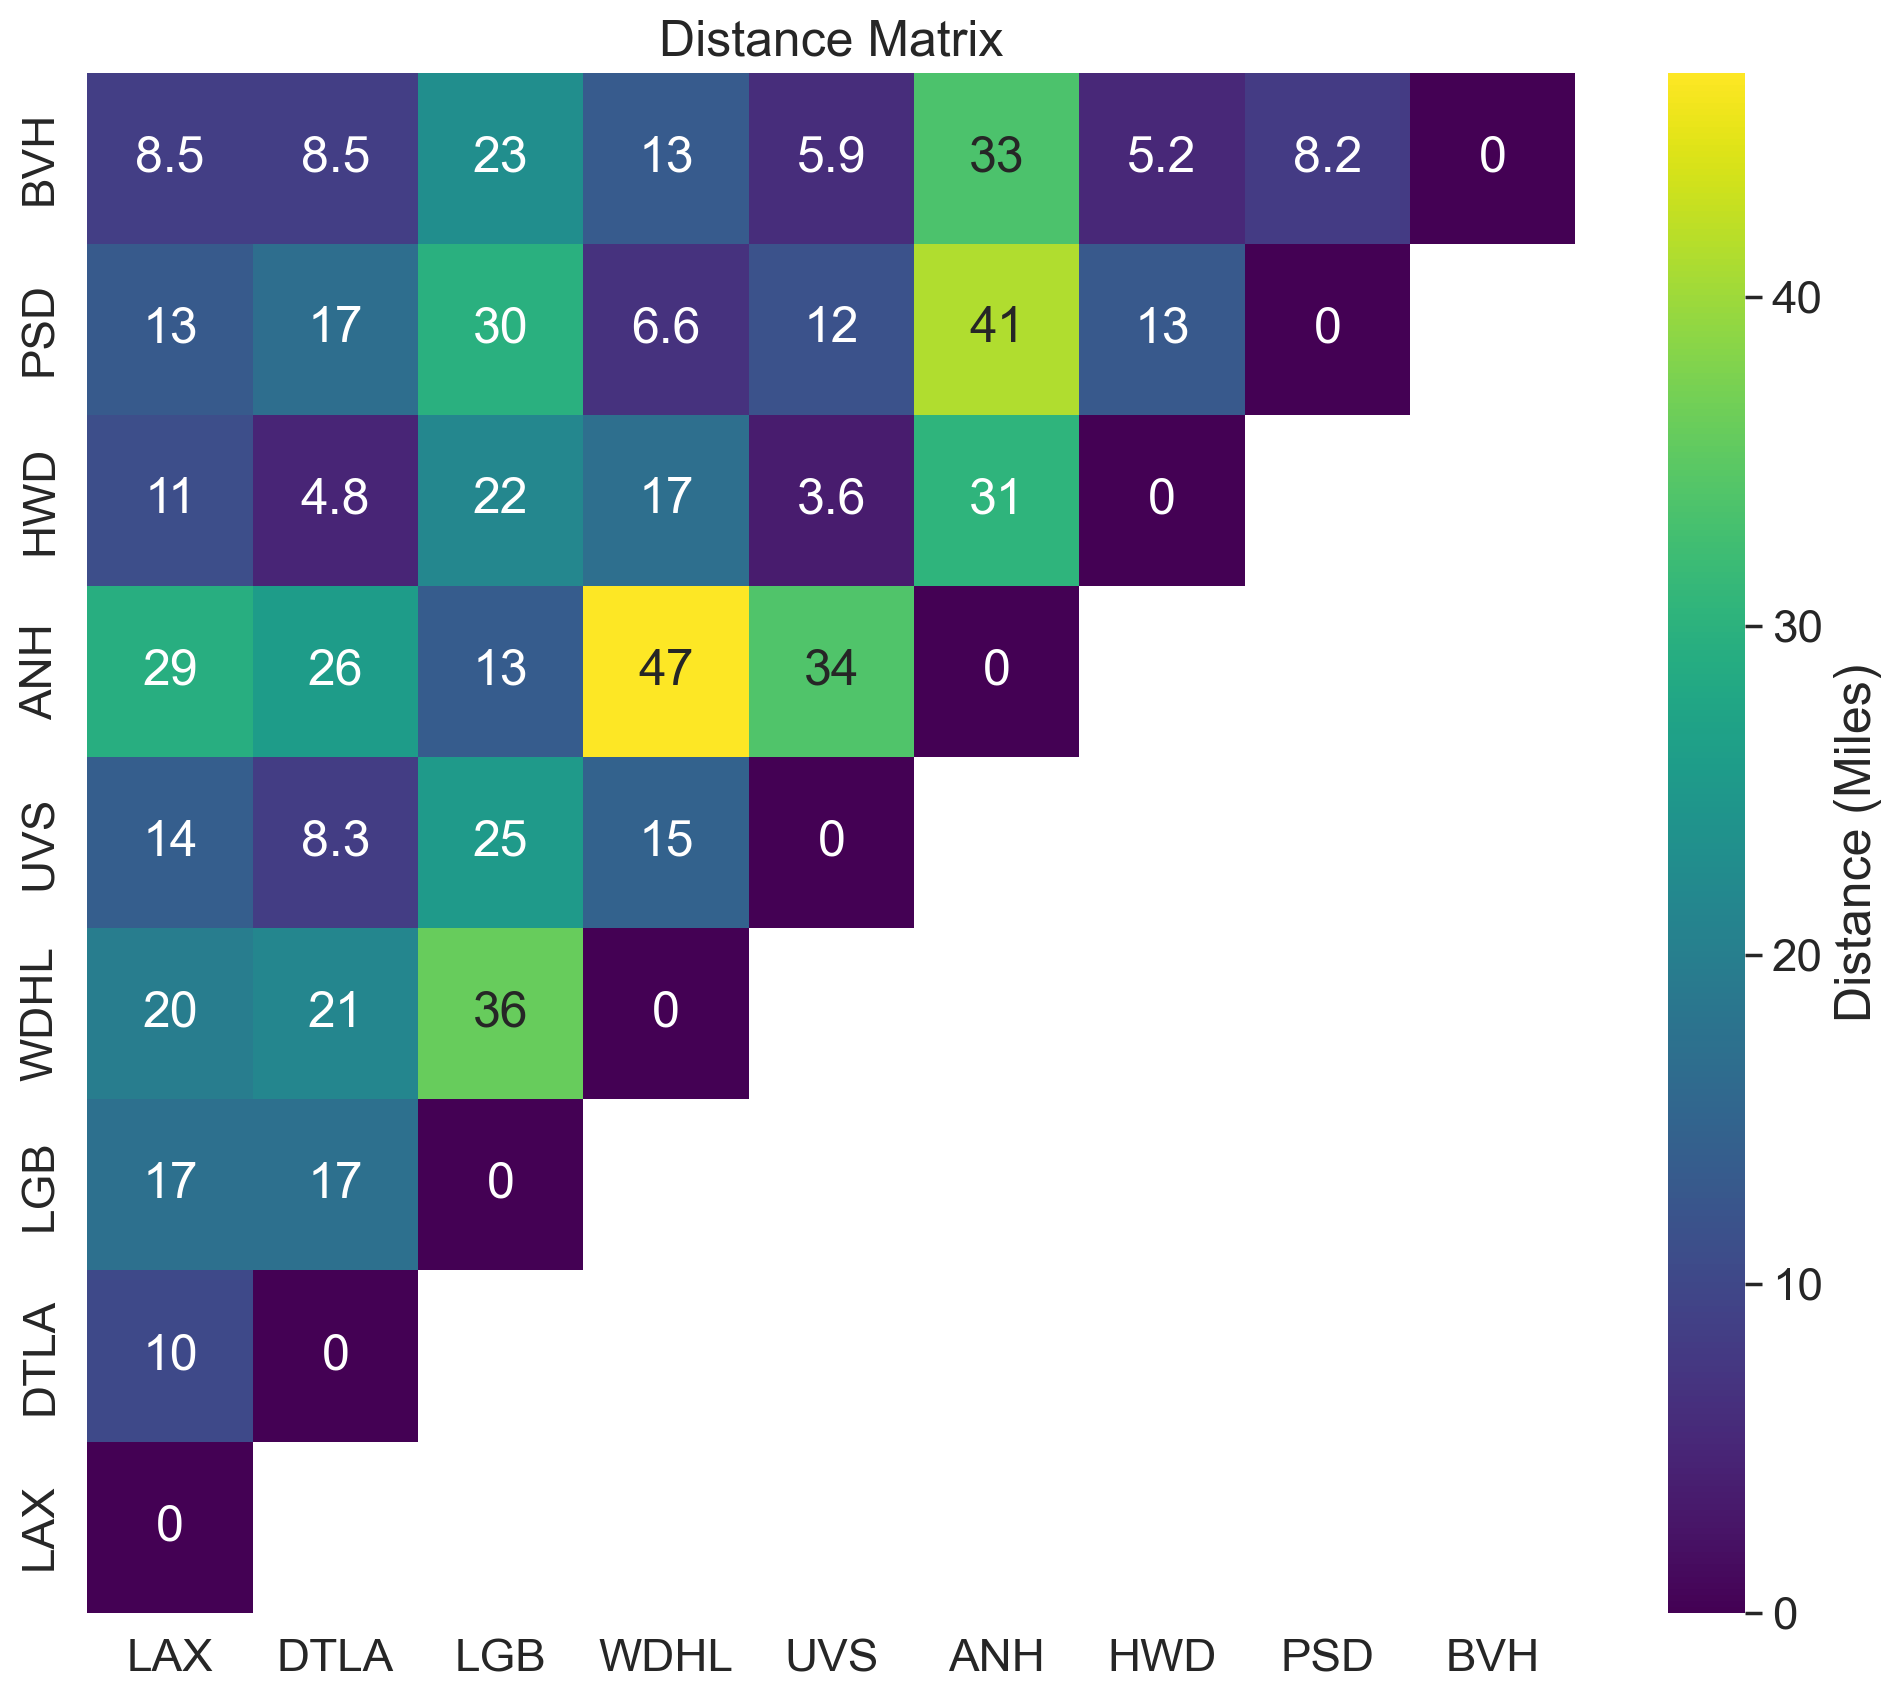

In [286]:
distance_matrix = calculate_distances_in_meters(coordinates)
mask = np.triu(np.ones_like(distance_matrix, dtype=bool), k=1)

fig, ax = plt.subplots(dpi=200, figsize=(12,10))
sns.heatmap(distance_matrix, annot=True, cmap='viridis', ax=ax,
            cbar_kws={'label': 'Distance (Miles)'}, mask=mask)
yticklabels = vertiports[::-1]

ax.set(yticklabels=list(vertiport_dict.values()), 
        xticklabels=list(vertiport_dict.values()), 
        title='Distance Matrix');
ax.invert_yaxis()
plt.grid(False)

In [279]:
flight_time = np.zeros(shape=distance_matrix.shape)
for i in range(distance_matrix.shape[0]):
    for j in range(distance_matrix.shape[1]):
        distance = distance_matrix[i][j]
        cruise_speed = 180/12 # miles per 5 minutes
        if i != j:
            flight_time[i][j] = 2 + np.ceil(distance / cruise_speed)

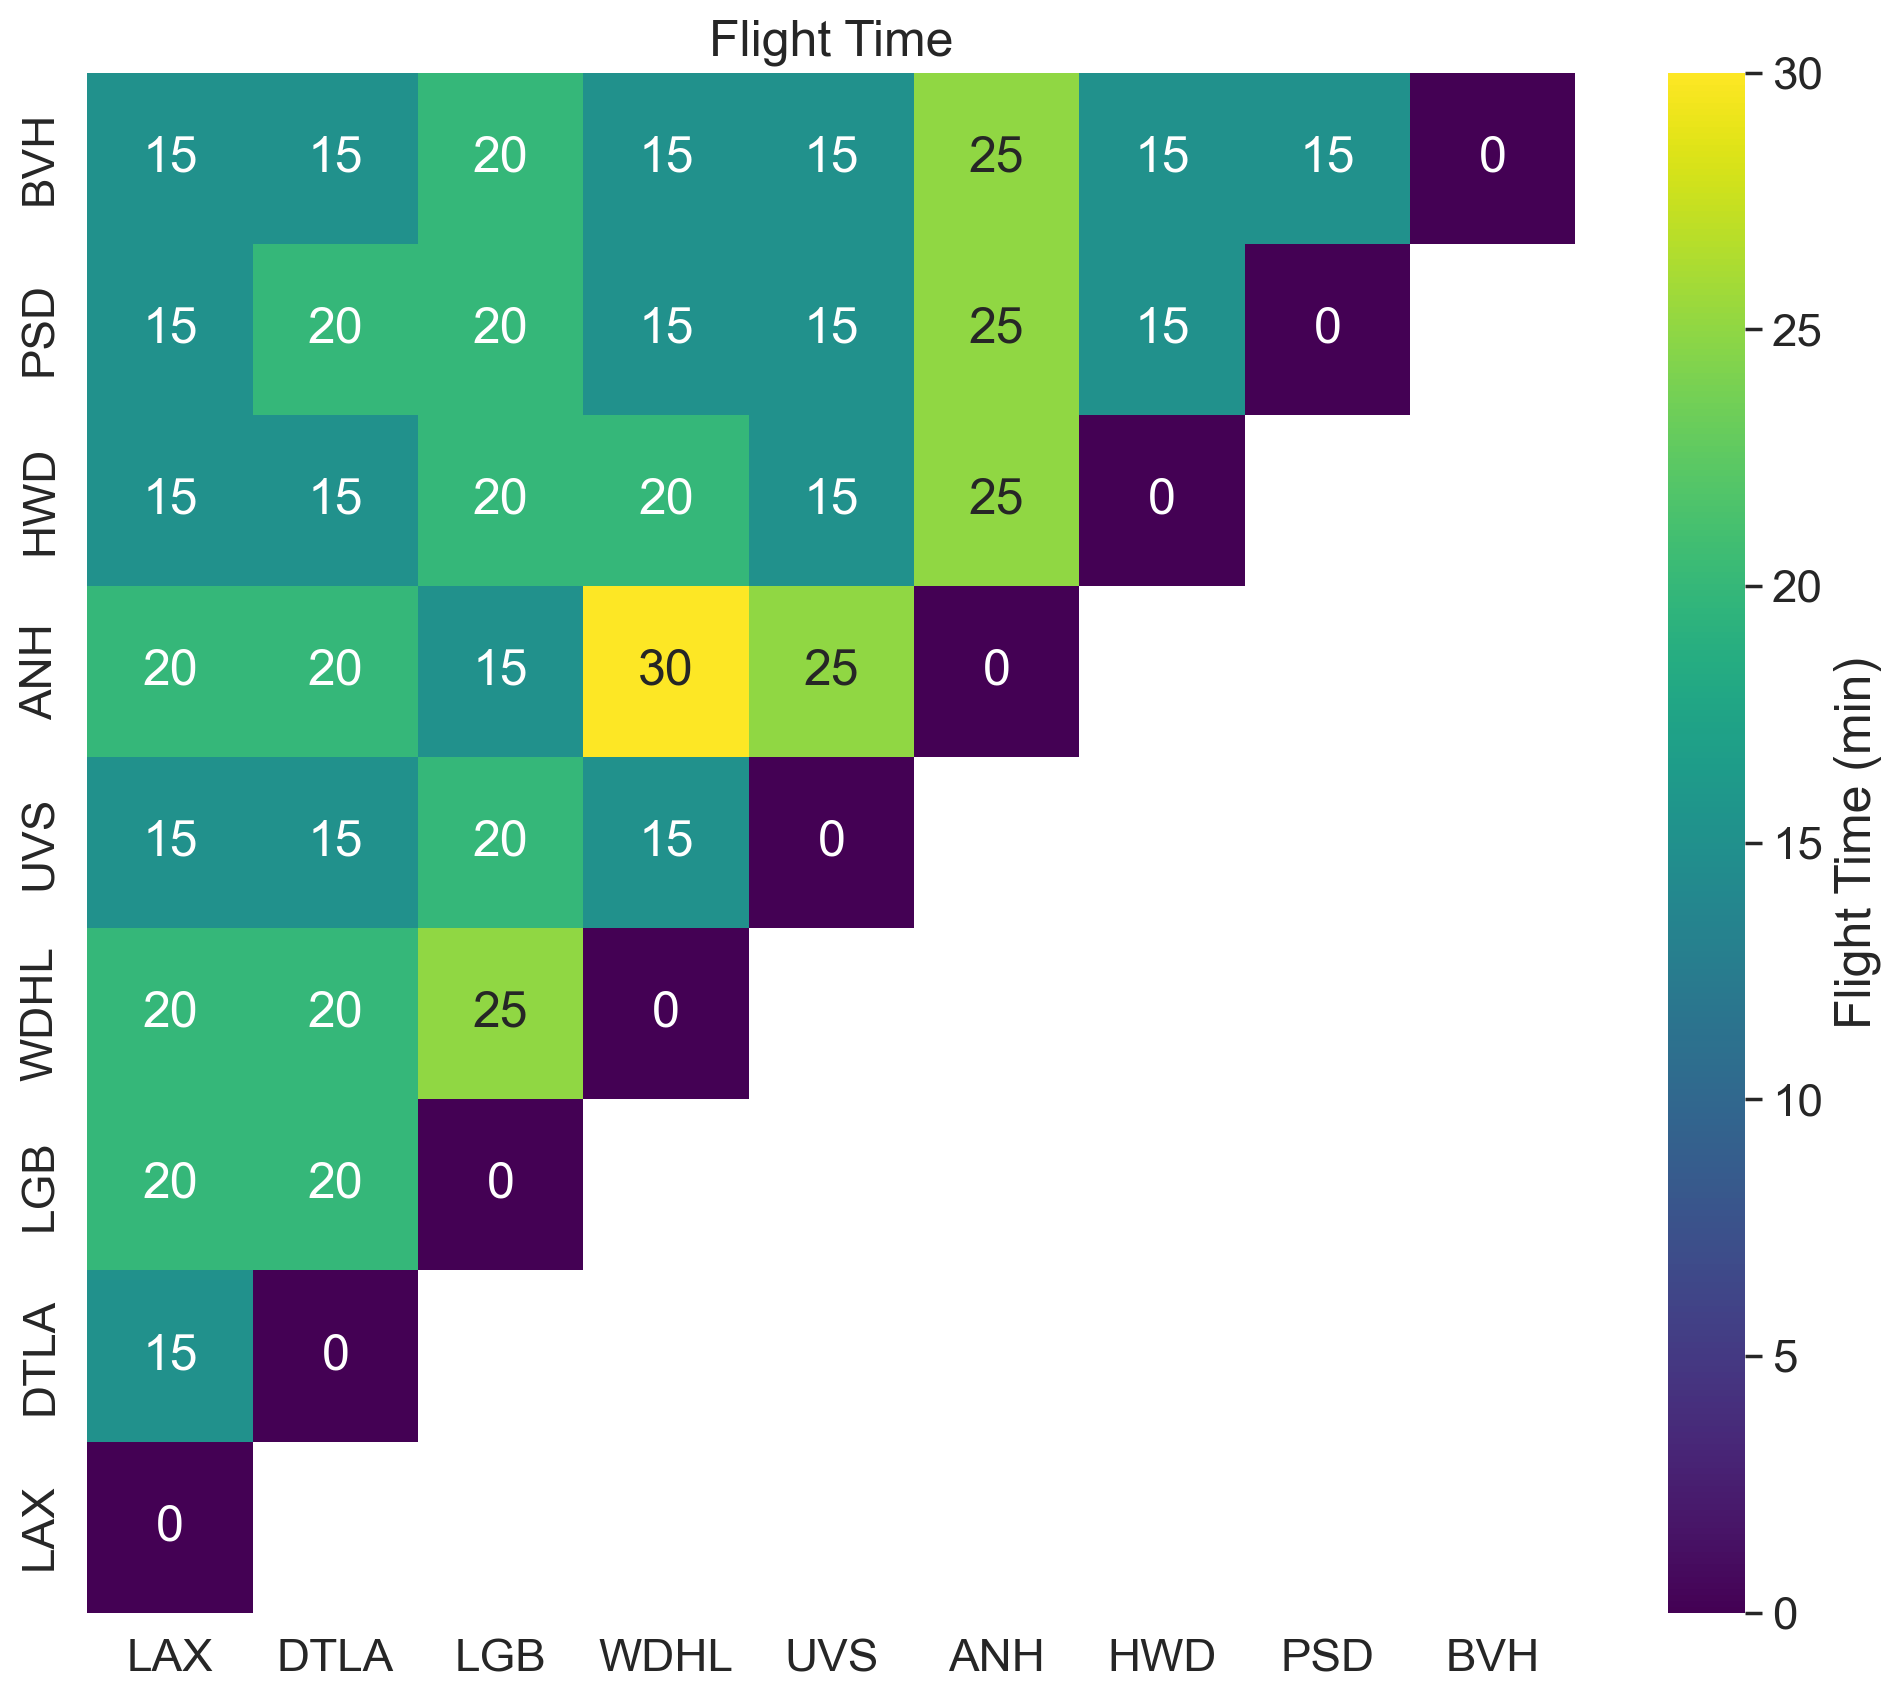

In [280]:
fig, ax = plt.subplots(dpi=200, figsize=(12,10))
sns.heatmap(flight_time*5, annot=True, cmap='viridis', ax=ax,
            cbar_kws={'label': 'Flight Time (min)'}, mask=mask)
yticklabels = vertiports[::-1]

ax.set(yticklabels=list(vertiport_dict.values()), 
        xticklabels=list(vertiport_dict.values()), 
        title='Flight Time');
ax.invert_yaxis()
plt.grid(False)

In [283]:
energy_consumption = np.zeros(shape=distance_matrix.shape)
for i in range(distance_matrix.shape[0]):
    for j in range(distance_matrix.shape[1]):
        distance = distance_matrix[i][j]
        if i!= j:
            if distance <= 20:
                energy_consumption[i][j] = distance * 1 + 5
            else:
                energy_consumption[i][j] = 20 + (distance - 20) * 0.65 + 5
energy_consumption = energy_consumption / 160 * 100
        

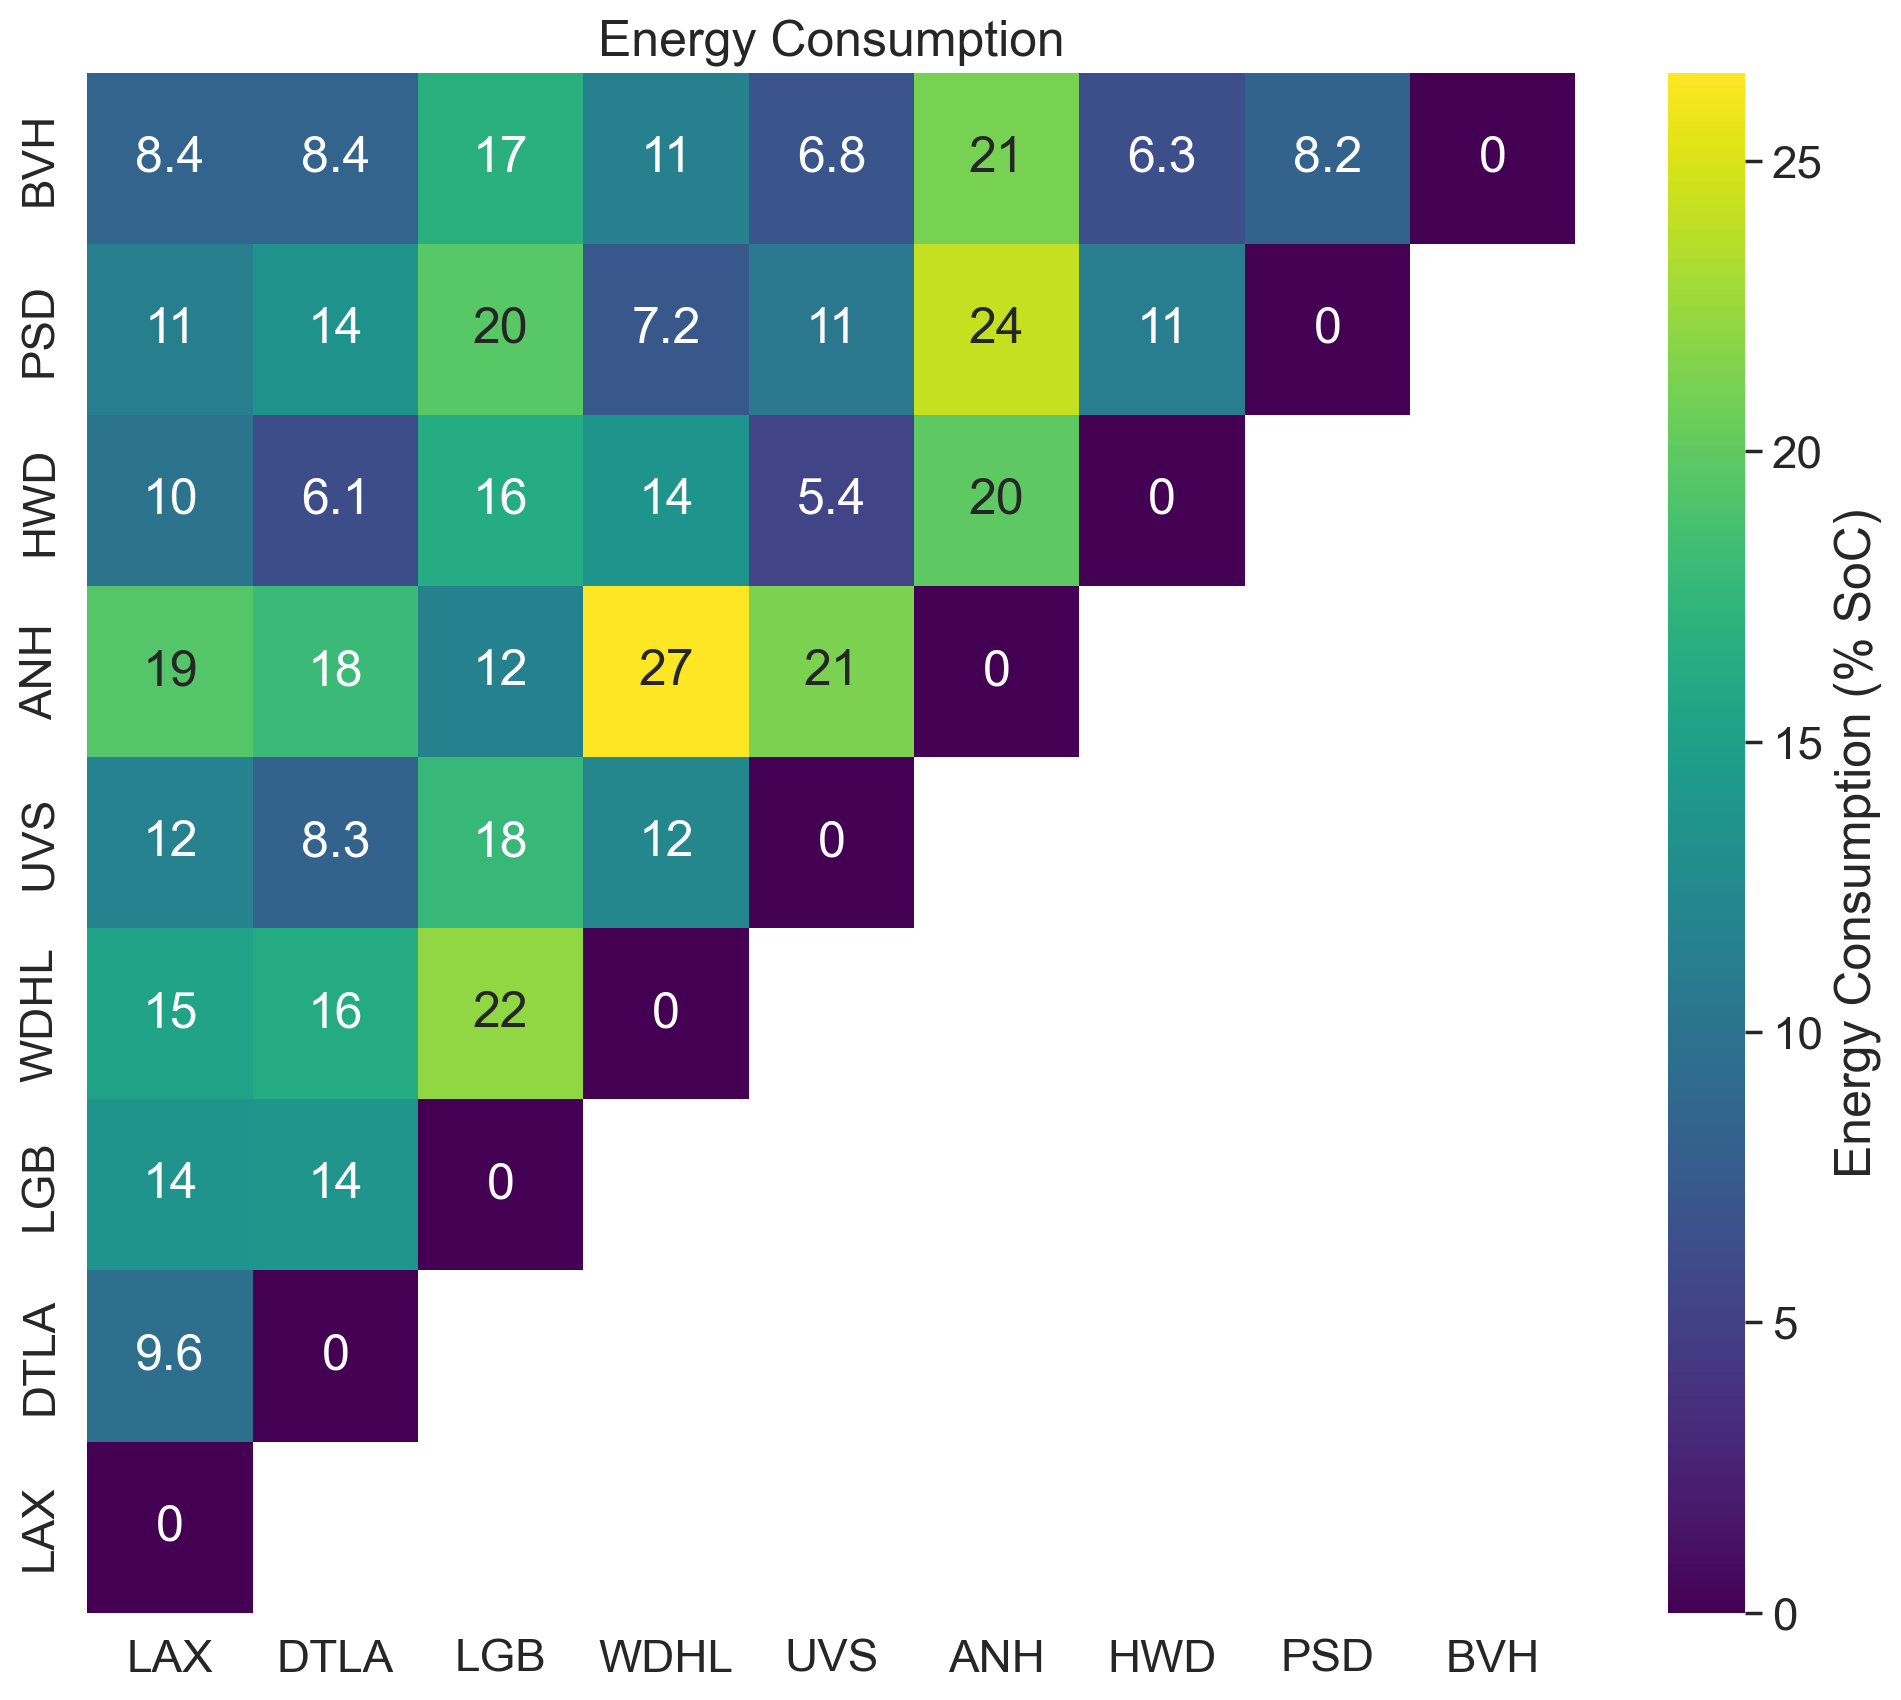

In [284]:
fig, ax = plt.subplots(dpi=200, figsize=(12,10))
sns.heatmap(energy_consumption, annot=True, cmap='viridis', ax=ax,
            cbar_kws={'label': 'Energy Consumption (% SoC)'}, mask=mask)
yticklabels = vertiports[::-1]

ax.set(yticklabels=list(vertiport_dict.values()), 
        xticklabels=list(vertiport_dict.values()), 
        title='Energy Consumption');
ax.invert_yaxis()
plt.grid(False)

In [99]:
def inverse_cdf(cumulative_pmf, num_samples):
    samples = []
    for _ in range(num_samples):
        u = np.random.uniform(0, 1)
        sample_index = (u <= cumulative_pmf)
        samples.append(np.argmax(sample_index))

    samples = np.array(samples)
    return samples

In [74]:
def obtain_demand_dict(df, existing_dict=None):
    if existing_dict is not None:
        demand_dict = existing_dict
    else:
        demand_dict = {}
        
    df_grouped = df.groupby(['origin', 'destination', 'schedule']).size().reset_index(name='count')
    for i, row in df_grouped.iterrows():
        demand_dict[(int(row['origin']), int(row['destination']), int(row['schedule']))] = int(row['count'])
    return demand_dict

In [287]:
energy_consumption = (energy_consumption/2.5).astype(int)
od_matrix = np.array([[0,1,1,1,1,1,1,1,1],
                      [1,0,1,1,1,1,1,1,1],
                      [1,1,0,1,1,1,1,1,1],
                      [1,1,1,0,1,1,1,1,1],
                      [1,1,1,1,0,1,1,1,1],
                      [1,1,1,1,1,0,1,1,1],
                      [1,1,1,1,1,1,0,1,1],
                      [1,1,1,1,1,1,1,0,1],
                      [1,1,1,1,1,1,1,1,0]])

coordinates = np.array([(33.94417072663332, -118.40248449470265),
                        (34.043119432990345, -118.26720629762752),
                        (33.81606030845284, -118.15122129260827),
                        (34.17160155814583, -118.60525790222589),
                        (34.13843197335217, -118.35511311047983),
                        (33.812102161009804, -117.91897753216998),
                        (34.09174681098575, -118.32725521957076),
                        (34.08807589928915, -118.55063573741867),
                        (34.06666969690935, -118.4114352069469)])

In [293]:
flight_time = flight_time.astype(int)

In [294]:
network = ChargingNetwork(vertiports, flight_time, energy_consumption, od_matrix)
nodes, supply, edges, cost, c = network.populate_network()

In [297]:
model_name = 'STAR_8_0714'

In [298]:
########### This is only ran once to generate the mps file ############
m = Model("LagrangianRelaxation")
# Create variables
var_keys = m.addVars(edges, name=lambda e: f"flow_{e[0]}_{e[1]}", lb=0)
# Create flow conservation constraints
m.setParam('Threads', 4)
for n in tqdm(nodes):
    m.addConstr(quicksum(var_keys[i, j] for i, j in edges if j == n) -
    quicksum(var_keys[i, j] for i, j in edges if i == n) == supply.get(n, 0), f"node_{n}")
m.update()
m.write(f'../output/star_network/LR/{model_name}.mps')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-07
Set parameter Threads to value 4


  6%|▌         | 5244/87320 [08:34<2:26:20,  9.35it/s]